In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import numpy as np
import scipy
from matplotlib import pyplot as plt
import IPython
from pathlib import Path
import re
import pprint
import csv

2025-01-23 17:53:06.795186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737672786.859027    3323 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737672786.877753    3323 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 17:53:07.004704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.0


## Load participant data

In [8]:
# Define some expected data categories
session_types = ['s', 'v']
session_type_regex = '|'.join(session_types)
trial_types = ['Targets'] #, 'nonTargets', 'alteredLuminance']

# Get list of available data files
data_root = Path('pupillometry')
data_files = data_root.glob('s*_cleaned_raw.mat')

# Get subject demographic info:
demographic_data_file = data_root / 'uber_data_20250122.csv'
demographic_info = {}
int_fields = ['MOCA', 'MOCA_memory', 'NART_raw', 'age', 'diastolic_brachial', 'english_native', 'general_health', 'heart_rate', 'systolic_brachial', 'trailsb', 'years_education']
with open(demographic_data_file, mode='r', encoding='utf-8-sig') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        subject_num = row['subject']
        del row['subject']
        demographic_info[subject_num] = row
        for int_field in int_fields:
            try:
                demographic_info[subject_num][int_field] = int(demographic_info[subject_num][int_field])
            except ValueError:
                pass

# Build dictionary of data files organized first by subject number, then by session type
data_files_dict = {}
for file in data_files:
    match = re.search('s([0-9]+)(['+session_type_regex+'])_cleaned_raw\.mat', file.name)
    if match:
        subject_num, session_type = match.groups()
        if session_type not in session_types:
            error('unknown session type:', session_type)
        if subject_num in data_files_dict:
            data_files_dict[subject_num][session_type] = file
        else:
            data_files_dict[subject_num] = {session_type:file}

# Get list of subjects found
subject_nums = list(data_files_dict.keys())

# Delete subjects that don't have both a sham and verum session
for subject_num in subject_nums:
    for session_type in session_types:
        if session_type not in data_files_dict[subject_num]:
            del data_files_dict[subject_num]
            break

# Update list of subjects found
subject_nums = list(data_files_dict.keys())

data = {}
for subject_num in subject_nums:
    data[subject_num] = {}
    for session_type in session_types:
        session_data = scipy.io.loadmat(data_files_dict[subject_num][session_type])
        data[subject_num][session_type] = {}
        for trial_type in trial_types:
            data[subject_num][session_type][trial_type] = session_data[trial_type]

print('Example subject data:')
for subject_num in subject_nums[0:2]:
    print(subject_num, '(age='+str(demographic_info[subject_num]['age'])+')')
    for session_type in session_types:
        print('  ', session_type)
        for trial_type in trial_types:
            print('    ', trial_type, data[subject_num][session_type][trial_type].shape)

Example subject data:
610 (age=32)
   s
     Targets (30, 2401)
   v
     Targets (30, 2401)
578 (age=32)
   s
     Targets (30, 2401)
   v
     Targets (30, 2401)


In [9]:
# Make training and test set:
nTrain = 1000
nTest = 1000

num_trials = 10
num_trial_types = len(trial_types)
trial_length = data[subject_nums[0]][session_types[0]][trial_types[0]].shape[1]
input_shape = [trial_length, num_trials, num_trial_types]

rng = np.random.default_rng()

def grabTrials(session_data):
    data = np.zeros(input_shape)
    for k, trial_type in enumerate(trial_types):
        trial_choices = np.sort(rng.choice(session_data[trial_type].shape[0], size=num_trials, replace=False))
        data[:, :, k] = session_data[trial_type][trial_choices, :].T
    return data

x_train = np.zeros([nTrain]+input_shape)
y_train = np.zeros(nTrain, dtype='int')
for k in range(nTrain):
    subject_num = rng.choice(subject_nums)
    session_type_idx = rng.choice(len(session_types))
    session_type = session_types[session_type_idx]
    session_data = data[subject_num][session_type]
    x_train[k, ...] = grabTrials(session_data)
    y_train[k] = session_type_idx

x_test = np.zeros([nTest]+input_shape)
y_test = np.zeros(nTest, dtype='int')
for k in range(nTest):
    subject_num = rng.choice(subject_nums)
    session_type_idx = rng.choice(len(session_types))
    session_type = session_types[session_type_idx]
    session_data = data[subject_num][session_type]
    x_test[k, ...] = grabTrials(session_data)
    y_test[k] = session_type_idx

print('x_train:')
print(x_train.shape)
print('y_train:')
print(y_train.shape)

print('x_test:')
print(x_test.shape)
print('y_test:')
print(y_test.shape)

x_train:
(1000, 2401, 10, 1)
y_train:
(1000,)
x_test:
(1000, 2401, 10, 1)
y_test:
(1000,)


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((2401, 10)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(2)
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])


In [11]:
probabilities = tf.nn.softmax(model(x_train[:1]).numpy())
probabilities
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,330 (75.51 KB)

 Trainable params: 19,330 (75.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print('**** Training: ****')
model.fit(x_train, y_train, epochs=50)
print()
print('**** Testing: ****')
model.evaluate(x_test,  y_test, verbose=1)

**** Training: ****
Epoch 1/50


2025-01-23 17:54:29.713253: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 96040000 exceeds 10% of free system memory.


32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 493ms/step - accuracy: 0.5014 - loss: 0.6997
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.5316 - loss: 0.6898
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 493ms/step - accuracy: 0.5300 - loss: 0.6953
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 493ms/step - accuracy: 0.5507 - loss: 0.6818
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.5098 - loss: 0.6897
Epoch 6/50
28/32 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step - accuracy: 0.5451 - loss: 0.6815 

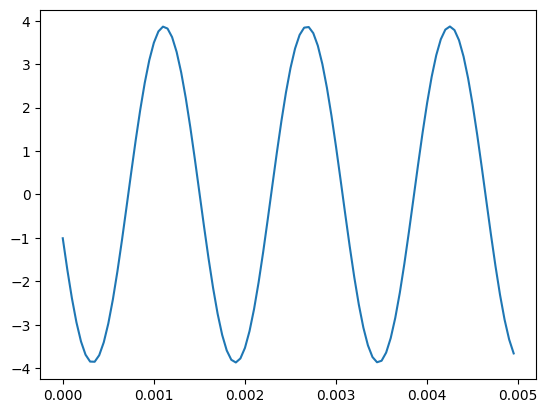

Predicted freq:    635.2 Hz
Actual freq:       637.5 Hz
Frequency error:   2.3 Hz
Frequency % error: 0.4%


In [20]:
# Interactive random test:

k = np.random.randint(0, x_test.shape[0])
x = x_test[k, np.newaxis, :]

plt.plot(t[0:100], x[0, 0:100])
plt.show()

predictedFreq = model(x).numpy()[0]
print('Predicted freq:    {f:.01f} Hz'.format(f=predictedFreq[0]))
print('Actual freq:       {f:.01f} Hz'.format(f=y_test[k]))
print('Frequency error:   {f:.01f} Hz'.format(f=abs(predictedFreq[0] - y_test[k])))
print('Frequency % error: {f:.01f}%'.format(f=100*abs(predictedFreq[0] - y_test[k])/y_test[k]))


In [118]:
#Model record:

In [ ]:
# 61%
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(input_shape),
  tf.keras.layers.Conv2D(10, (1, 50), dilation_rate=(1, 10)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(session_types))
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

# 65%:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(input_shape),
  tf.keras.layers.Conv2D(10, (1, 50), dilation_rate=(1, 10)),
  tf.keras.layers.Conv2D(6, (1, 10), dilation_rate=(1, 5)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(session_types))
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

# 40 epochs => 68%:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(input_shape),
  tf.keras.layers.Conv2D(10, (1, 50), dilation_rate=(1, 10)),
  tf.keras.layers.Conv2D(3, (1, 10)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(session_types))
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

# 20 epochs => 49%
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(input_shape),
  tf.keras.layers.Conv2D(10, (1, 50), dilation_rate=(1, 10)),
  tf.keras.layers.Conv2D(20, (1, 10)),
  tf.keras.layers.MaxPool2D((1, 10)),
  tf.keras.layers.Conv2D(30, (1, 10)),
  tf.keras.layers.MaxPool2D((1, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(session_types))
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

# Target trials only
# 110 epochs => 
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(input_shape),
  tf.keras.layers.Conv1D(10, 50, dilation_rate=10),
  tf.keras.layers.Conv1D(3, 10),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(session_types))
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])